In [1]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Video

In [109]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:
    def imshow(img):
        vmin = 0
        vmax = img.max()
        if vmax > 1:
            vmax = 255
        if vmax > 1:
            img = img.astype(np.uint8)
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        plt.axis('off')
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        else:
            plt.imshow(img, vmin=vmin, vmax=vmax)
        plt.show()

Single frame extraction to detect objects

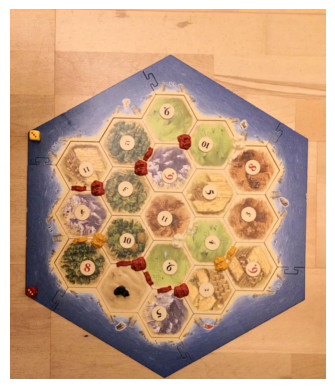

Frame extracted


In [115]:
def get_frame(path, frame_number):
    video_path = "input_data/" + path + ".mp4"
    cap = cv2.VideoCapture(video_path)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    if ret:
        imshow(frame)
        print("Frame extracted")
        return frame
    else:
        print("Failed to extract frame.")
        return None

    # Release the video capture object
    cap.release()


frame = get_frame('easy1', 0)

## **1. Object detection** ##

### **1.1. Dices detection (by board position)** ###

In [121]:
def filter_lines_by_slope(lines, vertical_threshold=1):
    vertical_lines = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1
        
        # Calculate slope
        if abs(dx) < vertical_threshold:  # Vertical line
            vertical_lines.append(((x1, y1), (x2, y2)))
    
    return vertical_lines

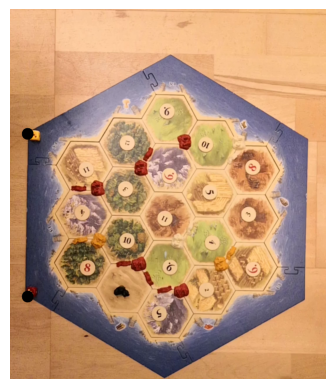

((60, 982), (60, 426))

In [126]:
def detect_dices(frame, path):
    frame_bin = np.where((frame[..., 0] < 10) | (frame[..., 1] < 10) | (frame[..., 2] > 140), 255, 0).astype(np.uint8)
    frame_bin = 255-frame_bin
    lines = cv2.HoughLinesP(frame_bin, 0.1, np.pi / 180, threshold=80, minLineLength=500, maxLineGap=10)
    vertical_lines = filter_lines_by_slope(lines)
    left_vertical_line = min(vertical_lines, key=lambda line: line[0][0])  # Min x1

    output = frame.copy()

    cv2.circle(output, (left_vertical_line[0][0], left_vertical_line[0][1]), 20, (0, 0, 0), -1)
    cv2.circle(output, (left_vertical_line[1][0], left_vertical_line[1][1]), 20, (0, 0, 0), -1)

    imshow(output)
    file_name = 'dices_detection_' + path + '.jpg'
    # cv2.imwrite(file_name, output)
    return left_vertical_line

detect_dices(frame, 'easy1')

### **1.2. Number tokens detection** ###

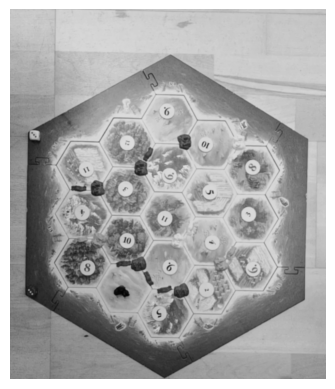

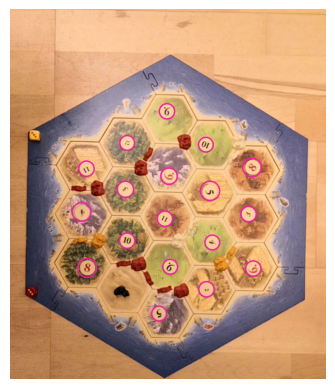

Number tokens count: 18


In [128]:
def detect_tokens(frame, path):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(frame_gray, (5, 5), 0)
    imshow(blurred)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 40, 
                            param1=10, param2=45, minRadius=20, maxRadius=35)

    img_result = frame.copy()
    if circles is not None:
        circles = np.round(circles[0,]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(img_result, (x, y), r, (160, 32, 240), 3)  # Draw circle
        
    imshow(img_result)
    file_name = 'tokens_detection_' + path + '.jpg'
    # cv2.imwrite(file_name, img_result)
    print("Number tokens count:", len(circles))

detect_tokens(frame, 'easy1')

### **1.3. Detection for all inputs** ###

In [132]:
import random

def detection(paths):
    for path in paths:
        if path != 'medium2':     # unfortunately for this input file detect dice function struggles
            frame0 = get_frame(path, 0)
            detect_dices(frame0, path)
        random_frame = get_frame(path, random.randint(0, 1500))
        detect_tokens(random_frame, path)

paths = ['easy1', 'easy2', 'easy3', 'medium1', 'medium2', 'medium3', 'difficult1', 'difficult2', 'difficult3']
# detection(paths)

### **1.4. Board detection** ###

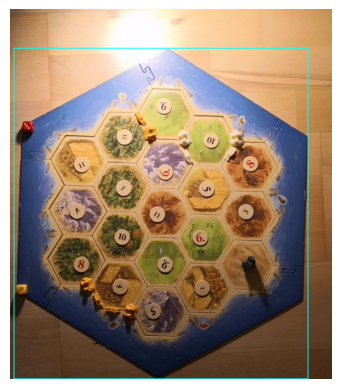

Board detected!


In [419]:
_frame = frame.copy()
_frame = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(_frame, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)
edges = (edges > 0)
# imshow(edges * 255)

coords = np.column_stack(np.where(edges > 0))  # Array of (y, x) coordinates

# Find extreme points
leftmost = coords[np.argmin(coords[:, 1])]   # Minimum x
rightmost = coords[np.argmax(coords[:, 1])]  # Maximum x
topmost = coords[np.argmin(coords[:, 0])]    # Minimum y
bottommost = coords[np.argmax(coords[:, 0])] # Maximum y

# Convert to (x, y) format
leftmost = (leftmost[1], leftmost[0])
rightmost = (rightmost[1], rightmost[0])
topmost = (topmost[1], topmost[0])
bottommost = (bottommost[1], bottommost[0])

# Draw the extreme points on the original image
output_image = cv2.cvtColor(_frame, cv2.COLOR_GRAY2BGR)
cv2.circle(output_image, leftmost, 5, (0, 0, 255), -1)      # Red
cv2.circle(output_image, rightmost, 5, (0, 255, 0), -1)     # Green
cv2.circle(output_image, topmost, 5, (255, 0, 0), -1)       # Blue
cv2.circle(output_image, bottommost, 5, (255, 255, 0), -1)  # Yellow

top_left = (leftmost[0], topmost[1])         # (min_x, min_y)
bottom_right = (rightmost[0], bottommost[1]) # (max_x, max_y)

_frame = frame.copy()
cv2.rectangle(_frame, top_left, bottom_right, (255, 255, 0), 2)

imshow(_frame)
print("Board detected!")

## **2. Object tracking** ##

### **2.1. Dice tracking** ###

In [80]:
catan = cv2.VideoCapture("input_data/difficult2.mp4")
if catan.isOpened():
    print("Video loaded")

catan_width = int(catan.get(3))
catan_height = int(catan.get(4))

print(catan_height, catan_width)

catan_fps = catan.get(cv2.CAP_PROP_FPS)
print(catan_fps)

Video loaded
1284 1080
29.000977772561022


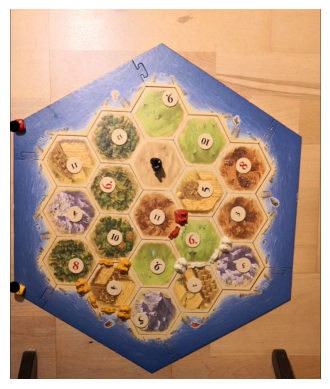

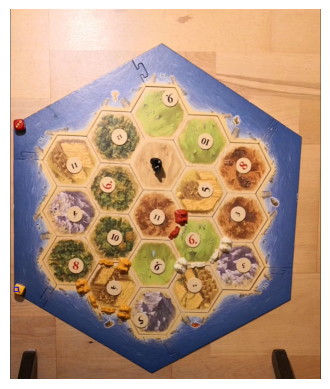

In [ ]:
catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = catan.read()

dices = detect_dices(frame)
xb = dices[0][0]
yb =dices[0][1]

side_length = 15

x = int(xb)
y = int(yb)
w, h = side_length, side_length
track_window = (x, y, w, h)
cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2)
imshow(frame)

In [86]:
dice_track = cv2.VideoWriter(
    "./dice_track_meanShift.avi",
    cv2.VideoWriter_fourcc(*"DIVX"),
    catan_fps,
    (catan_width, catan_height),
)

catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = catan.read()

if ret:
    roi = frame[y : y + h, x : x + w]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(
        hsv_roi, np.array((0.0, 60.0, 32.0)), np.array((180.0, 255.0, 255.0))
    )
    roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
    cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

    # Set termination criteria for MeanShift
    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

    # Run MeanShift algorithm on subsequent frames
    f = 0
    while catan.isOpened() and f < 1200:
        ret, frame = catan.read()
        if not ret:
            break

        # Convert the frame to HSV and back project using roi_hist
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

        # Apply MeanShift to find the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # Draw the tracking rectangle
        x, y, w, h = track_window
        dice_track.write(cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2))
        f+=1
else:
    print('Problem with ret')

dice_track.release()

In [87]:
!ffmpeg -hide_banner -loglevel error -i dice_track_meanShift.avi -y dice_track_meanShift.mp4

In [88]:
Video.from_file("./dice_track_meanShift.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

### **2.2 Thief tracking 1** ###

In [15]:
catan = cv2.VideoCapture("input_data/easy1.mp4")
if catan.isOpened():
    print("Video loaded")

catan_width = int(catan.get(3))
catan_height = int(catan.get(4))

print(catan_height, catan_width)

catan_fps = catan.get(cv2.CAP_PROP_FPS)
print(catan_fps)

Video loaded
1264 1080
29.00099787788183


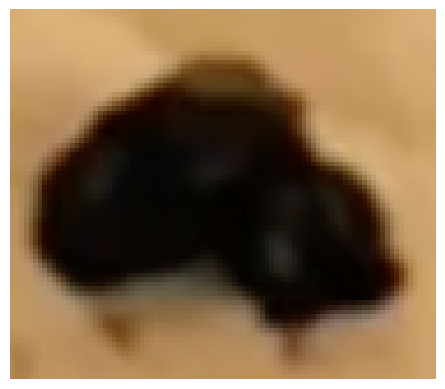

In [199]:
thief = cv2.imread("thief_template_3.jpg", 1).astype(np.uint8)
_, w, h = thief.shape[::-1]
w = w
h = h
imshow(thief)

In [200]:
catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = catan.read()
res = cv2.matchTemplate(frame, thief, cv2.TM_CCORR_NORMED)
loc = np.where(res >= 0.91)

y, x = loc[0][0] +2, loc[1][0] + 18
track_window = (x, y, w, h)
roi = frame[x : x + w, y: y+h]

hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(
    hsv_roi, np.array((0.0, 60.0, 32.0)), np.array((180.0, 255.0, 255.0))
)
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

In [201]:
thief_track = cv2.VideoWriter(
    "./thief_track_meanShift.avi",
    cv2.VideoWriter_fourcc(*"DIVX"),
    catan_fps,
    (catan_width, catan_height),
)

catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
while catan.isOpened():
    ret, frame = catan.read()
    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        x, y, w, h = track_window
        thief_track.write(cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2))
    else:
        break

thief_track.release()

In [202]:
!ffmpeg -hide_banner -loglevel error -i thief_track_meanShift.avi -y thief_track_meanShift.mp4

In [203]:
Video.from_file("./thief_track_meanShift.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

### **Thief tracking 2** ###

In [361]:
catan = cv2.VideoCapture("input_data/easy1.mp4")
if catan.isOpened():
    print("Video loaded")

catan_width = int(catan.get(3))
catan_height = int(catan.get(4))

print(catan_height, catan_width)

catan_fps = catan.get(cv2.CAP_PROP_FPS)
print(catan_fps)

Video loaded
1264 1080
29.00099787788183


In [362]:
catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = catan.read()
x, y, w, h = 363, 942, 50, 50 # simply hardcoded the values
track_window = (x, y, w, h)
roi = frame[y : y + h, x : x + w]

hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(
    hsv_roi, np.array((0.0, 60.0, 32.0)), np.array((180.0, 255.0, 255.0))
)
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

In [363]:
dice_track = cv2.VideoWriter(
    "./dice_track_meanShift.avi",
    cv2.VideoWriter_fourcc(*"DIVX"),
    catan_fps,
    (catan_width, catan_height),
)

catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
while catan.isOpened():
    ret, frame = catan.read()

    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        x, y, w, h = track_window
        dice_track.write(cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2))
    else:
        break

dice_track.release()

In [364]:
!ffmpeg -hide_banner -loglevel error -i dice_track_meanShift.avi -y dice_track_meanShift.mp4

In [365]:
Video.from_file("./dice_track_meanShift.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')